In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import re
%matplotlib inline
from scipy.stats import skew
from scipy.special import boxcox1p
import tensorflow as tf
from tqdm import tqdm_notebook 
from sklearn.utils import shuffle 
import datetime 
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [4]:
data_url = "/home/jovyan/my_data/kagle/poke/"
test = pd.read_csv(data_url + "test.csv")  
train = pd.read_csv(data_url + "train.csv") 
train_ID = train['_id']
test_ID = test['_id']
train.drop("_id", axis = 1, inplace = True)
test.drop("_id", axis = 1, inplace = True)

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
print(train.shape,test.shape)
raw_y_train = train[["class"]]
y_train = train[["class"]].astype(str)
y_train = pd.get_dummies(y_train)
train = train.drop("class", axis=1)
all_data = pd.concat((train, test), axis=0)
print(all_data.shape, y_train.shape)

(10714, 184) (2681, 183)
(13395, 183) (10714, 6)


In [6]:
all_data = all_data.drop("pokestopDistanceKm", axis=1)
all_data["terrainType"] = all_data["terrainType"].astype(str)

# all_data = all_data.drop("city", axis=1)

In [7]:
# colls = ["appearedHour", "appearedMinute","weather", "weatherIcon"] 
# for c in colls:
#     if c in all_data:
#         lbl = LabelEncoder() 
#         lbl.fit(list(all_data[c].values)) 
#         all_data[c] = lbl.transform(list(all_data[c].values))       

In [8]:
print(all_data.shape)
print(all_data.columns)

(13395, 182)
Index(['appearedTimeOfDay', 'appearedHour', 'appearedMinute', 'terrainType',
       'closeToWater', 'city', 'continent', 'weather', 'temperature',
       'windSpeed',
       ...
       'cooc_142', 'cooc_143', 'cooc_144', 'cooc_145', 'cooc_146', 'cooc_147',
       'cooc_148', 'cooc_149', 'cooc_150', 'cooc_151'],
      dtype='object', length=182)


In [9]:
numeric_feats = all_data.select_dtypes(include=['float64']).columns
print(numeric_feats)
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness = skewness[abs(skewness["Skew"]) > 0.75]
print(skewness.head(20))
skewed_features = skewness.index

Index(['temperature', 'windSpeed', 'pressure', 'population_density',
       'gymDistanceKm'],
      dtype='object')
                         Skew
gymDistanceKm       16.429956
population_density   2.298167
windSpeed            1.268810


In [10]:
for feat in skewed_features:    
    all_data[feat] = boxcox1p(all_data[feat], 0.15)

In [11]:
numeric_feats = all_data.select_dtypes(include=['float64']).columns
print(numeric_feats)
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
print(skewness.head(20))

Index(['temperature', 'windSpeed', 'pressure', 'population_density',
       'gymDistanceKm'],
      dtype='object')
                        Skew
gymDistanceKm       6.647819
temperature         0.021409
pressure           -0.054793
windSpeed          -0.130106
population_density -0.551515


In [12]:
print(all_data.shape, train.shape, test.shape)
all_data = pd.get_dummies(all_data)
print(all_data.shape, train.shape, test.shape)
train = all_data[:10714]
test = all_data[10714:]
raw_test = test.copy()
print(all_data.shape, y_train.shape,train.shape, test.shape)
train, test, y_train, y_test = train_test_split(train, y_train, test_size=0.2, random_state=42)  

(13395, 182) (10714, 183) (2681, 183)
(13395, 317) (10714, 183) (2681, 183)
(13395, 317) (10714, 6) (10714, 317) (2681, 317)


In [13]:
train.head(10)

,appearedHour,appearedMinute,closeToWater,temperature,windSpeed,windBearing,pressure,population_density,urban,suburban,...,weather_Windy,weather_WindyandFoggy,weatherIcon_clear-day,weatherIcon_clear-night,weatherIcon_cloudy,weatherIcon_fog,weatherIcon_partly-cloudy-day,weatherIcon_partly-cloudy-night,weatherIcon_rain,weatherIcon_wind
2517,10,23,False,26.1,2.191258,126,1016.16,11.671481,True,True,...,0,0,0,1,0,0,0,0,0,0
3468,11,43,True,21.3,2.217019,204,1020.96,5.237055,False,False,...,0,0,1,0,0,0,0,0,0,0
2691,23,32,True,26.0,1.621776,175,1015.10,17.268686,True,True,...,0,0,0,0,0,0,0,1,0,0
9826,18,34,False,21.1,2.085871,239,1021.20,11.572126,True,True,...,0,0,1,0,0,0,0,0,0,0
9900,9,58,False,8.2,2.347111,259,1007.77,12.279167,True,True,...,0,0,0,1,0,0,0,0,0,0
10094,0,26,False,26.9,2.271109,314,1015.09,7.469404,False,False,...,0,0,1,0,0,0,0,0,0,0
6050,8,47,False,15.3,1.190382,172,1021.69,15.274249,True,True,...,0,0,0,0,0,0,0,0,1,0
8644,5,29,False,34.4,2.831573,261,1006.42,13.121057,True,True,...,0,0,0,1,0,0,0,0,0,0
9016,16,46,False,16.8,2.386441,19,1025.48,4.214591,False,False,...,0,0,0,0,1,0,0,0,0,0
7864,2,39,True,18.6,3.237728,248,1009.17,16.626652,True,True,...,0,0,0,0,0,0,1,0,0,0


In [14]:
for i in all_data.columns:
    print(i)

appearedHour
appearedMinute
closeToWater
temperature
windSpeed
windBearing
pressure
population_density
urban
suburban
midurban
rural
gymDistanceKm
gymIn100m
gymIn250m
gymIn500m
gymIn1000m
gymIn2500m
gymIn5000m
pokestopIn100m
pokestopIn250m
pokestopIn500m
pokestopIn1000m
pokestopIn2500m
pokestopIn5000m
cooc_1
cooc_2
cooc_3
cooc_4
cooc_5
cooc_6
cooc_7
cooc_8
cooc_9
cooc_10
cooc_11
cooc_12
cooc_13
cooc_14
cooc_15
cooc_16
cooc_17
cooc_18
cooc_19
cooc_20
cooc_21
cooc_22
cooc_23
cooc_24
cooc_25
cooc_26
cooc_27
cooc_28
cooc_29
cooc_30
cooc_31
cooc_32
cooc_33
cooc_34
cooc_35
cooc_36
cooc_37
cooc_38
cooc_39
cooc_40
cooc_41
cooc_42
cooc_43
cooc_44
cooc_45
cooc_46
cooc_47
cooc_48
cooc_49
cooc_50
cooc_51
cooc_52
cooc_53
cooc_54
cooc_55
cooc_56
cooc_57
cooc_58
cooc_59
cooc_60
cooc_61
cooc_62
cooc_63
cooc_64
cooc_65
cooc_66
cooc_67
cooc_68
cooc_69
cooc_70
cooc_71
cooc_72
cooc_73
cooc_74
cooc_75
cooc_76
cooc_77
cooc_78
cooc_79
cooc_80
cooc_81
cooc_82
cooc_83
cooc_84
cooc_85
cooc_86
cooc_87
cooc_88
co

In [15]:
def get_batch_sample(train, y_train, batch):
    train = shuffle(train)
    sample_index = train[:batch].index    
    x_sample = train.loc[sample_index]
    y_sample = y_train.loc[sample_index]
    return train, y_train,  x_sample, y_sample

In [16]:
tf.reset_default_graph()

input_data = tf.placeholder(dtype=tf.float32, 
                           shape=[None, train.shape[1]],
                           name='input_data') 

y_true = tf.placeholder(dtype=tf.float32, 
                        shape=[None, y_train.shape[1]],
                        name='y_true') 
lr_rate = tf.placeholder(dtype=tf.float32, name = 'lr_rate')

x1 = tf.layers.dense(input_data, 290, activation=tf.nn.selu, name='hidden1') 
x2 = tf.layers.dense(x1, 250, activation=tf.nn.selu, name='hidden2') 
x3 = tf.layers.dense(x2,220,activation=tf.nn.selu, name='hidden3')
x4 = tf.layers.dense(x3, 190, activation=tf.nn.selu, name='hidden4') 
x5 = tf.layers.dense(x4, 160, activation=tf.nn.selu, name='hidden5') 
x6 = tf.layers.dense(x5,130,activation=tf.nn.selu, name='hidden6')
x7 = tf.layers.dense(x6,100,activation=tf.nn.selu, name='hidden7')
x8 = tf.layers.dense(x7,70,activation=tf.nn.selu, name='hidden8')


y_pred = tf.layers.dense(x8, y_train.shape[1], name='output')

correct_prediction = tf.equal(tf.argmax(tf.nn.softmax(y_pred),1), tf.argmax(y_true,1))
compute_acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred))

update = tf.train.AdamOptimizer(learning_rate=lr_rate).minimize(loss)

In [29]:
batch = 100
epoch = 110
update_per_epoch = 100

sess = tf.Session()
sess.run(tf.global_variables_initializer())

# g_train_loss, g_valid_loss = [], []
# g_train_acc, g_valid_acc = [], []
# for drop_rate in [0.0, 0.05, 0.1, 0.2, 0.4]:
train_loss = []
train_acc = []
test_loss = []
test_acc = []
patience = 9
n_patience = 0
rate = 0.001
for i in tqdm_notebook(range(epoch)): 
    training_loss = 0
    training_acc = 0
    for j in range(update_per_epoch):
        train, y_train, x_batch,y_batch = get_batch_sample(train, y_train, batch)  
        tr_pred_batch, training_loss_batch, acc_batch, _ = sess.run([y_pred, loss, compute_acc, update], feed_dict={
            input_data:x_batch,
            y_true:y_batch,
            lr_rate:rate
#             ,l2: 0.001,
#             drp_rate: 0.0,
#             is_train: True
        })     

        training_loss += training_loss_batch
        training_acc += acc_batch       


    training_loss /= update_per_epoch
    training_acc /= update_per_epoch


    te_pre, te_loss, te_acc, = sess.run([y_pred, loss, compute_acc], feed_dict={
            input_data:test,
            y_true:y_test,
            lr_rate:rate
#             ,l2: 0.001,
#             drp_rate: 0.0,
#             is_train: False
        }) 
    
    train_loss.append(training_loss)
    train_acc.append(training_acc)  
    test_loss.append(te_loss)
    test_acc.append(te_acc)   
    
#     if te_acc > 0.54 and training_acc > 0.54 :
#         print("done")
#         break        
     
#     if te_loss > np.min(test_loss):
#         rate *= 0.85
#         n_patience += 1
#     else:
#          n_patience = 0
    
#     if n_patience >= patience:
#         print("The model didn't improve for %i rounds, break it!" % patience)
#         break
    
#     g_train_loss.append(train_loss)
#     g_valid_loss.append(test_loss)
#     g_train_acc.append(train_acc)
#     g_valid_acc.append(test_acc)
# sess.close()    

In [30]:
#drop gymDistanceKm
print(max(test_acc),max(train_acc))
print(rate)

0.548763 0.595399999022
0.001


Text(0.5,1,'Accuracy')

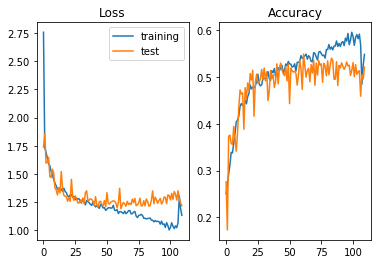

In [31]:
# epoch100  layer8
plt.figure(1)
plt.subplot(121)
plt.plot(range(len(train_loss)), train_loss, label='training')
plt.plot(range(len(test_loss)), test_loss, label='test')
plt.title('Loss')
plt.legend(loc='best')
plt.subplot(122)
plt.plot(range(len(train_acc)), train_acc, label='training')
plt.plot(range(len(test_acc)), test_acc, label='test')
plt.title('Accuracy')

In [23]:
print(test.shape)
output = sess.run(y_pred, {input_data:raw_test})
# output = np.floor(output)
output

(2143, 317)


array([[ 0.98210168, -1.32201266, -3.2688098 , -0.90766531,  0.63862246,
        -2.4150939 ],
       [ 0.93688965, -1.60652018, -3.89064908, -1.90086818,  1.31523561,
        -3.57041097],
       [-0.51395065,  1.55970597, -2.37425089,  1.23686492, -1.03447509,
        -0.37348089],
       ..., 
       [ 1.1382885 , -1.14510918, -4.15302563, -1.63900685,  0.97977859,
        -2.96236229],
       [ 0.39974558, -1.10096693, -3.63806963, -1.47880614,  0.76696521,
        -2.3468554 ],
       [ 0.37379903, -0.72016758, -3.71959043, -1.21595287,  0.60037559,
        -2.17622304]], dtype=float32)

In [21]:
def transfer_back(output):
    return_list = []
    for row in output:      
        max_num = max(row)
        max_index = list(row).index(max_num)
        return_list.append(max_index)
    return return_list    

In [22]:
output_list = transfer_back(output)
output_list[:20]

[0, 4, 1, 4, 1, 1, 3, 3, 3, 5, 4, 2, 5, 0, 5, 5, 0, 4, 1, 3]

In [425]:
# pd.DataFrame({"_id":test_ID, "class": output_list}).to_csv('test0824_6.csv', index =False)

In [426]:
output_list[:20]

[0, 4, 3, 4, 1, 1, 3, 3, 3, 5, 4, 2, 3, 0, 5, 5, 0, 4, 3, 3]

In [306]:
big_list = []
big_list.append(output_list)

In [309]:
len(big_list)

1